In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

Check CUDA installation

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti


In [3]:
bitcoin = pd.read_csv('data/btc.csv')
bitcoin

,unix_timestamp,entry_date,symbol,open_price,high_price,low_price,close_price,coin_volume
0,1417411980,2014-12-01 06:33:00+01:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
1,1417412400,2014-12-01 06:40:00+01:00,BTC-USD,300.00,300.00,300.00,300.00,0.010000
2,1417415040,2014-12-01 07:24:00+01:00,BTC-USD,370.00,370.00,370.00,370.00,0.010000
3,1417416600,2014-12-01 07:50:00+01:00,BTC-USD,370.00,370.00,370.00,370.00,0.026556
4,1417498140,2014-12-02 06:29:00+01:00,BTC-USD,377.00,377.00,377.00,377.00,0.010000
...,...,...,...,...,...,...,...,...
4911801,1722276180,2024-07-29 20:03:00+02:00,BTC-USD,67112.69,67240.21,67073.33,67231.12,16.786577
4911802,1722276240,2024-07-29 20:04:00+02:00,BTC-USD,67231.11,67270.14,67215.95,67232.61,14.302211
4911803,1722276300,2024-07-29 20:05:00+02:00,BTC-USD,67232.60,67266.29,67182.71,67255.35,12.772139
4911804,1722276360,2024-07-29 20:06:00+02:00,BTC-USD,67254.00,67290.65,67221.06,67256.28,16.879374


In [4]:
crypto_df = dict()
crypto_df['bitcoin'] = bitcoin

In [5]:
close_btc = crypto_df['bitcoin'].close_price


C:\Users\Doosheck\AppData\Local\Temp\ipykernel_21224\2182110235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['entry_date'] = pd.to_datetime(sampled_data['entry_date'], utc=True)


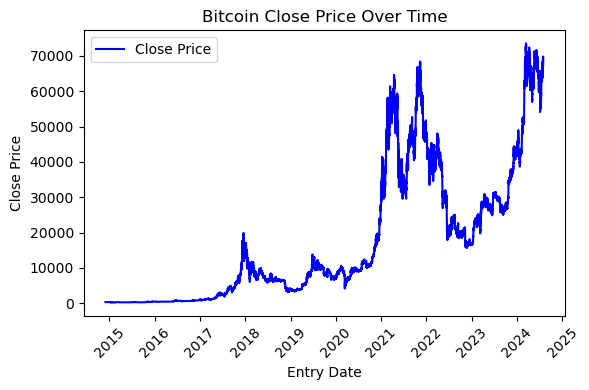

In [6]:
sampled_data = bitcoin.iloc[::100]

# Ensure 'entry_date' is a datetime object
sampled_data['entry_date'] = pd.to_datetime(sampled_data['entry_date'], utc=True)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(sampled_data['entry_date'], sampled_data['close_price'], label='Close Price', color='blue')
plt.xlabel('Entry Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
btc_prices = np.diff(bitcoin['close_price'])
btc_prices_csum = np.cumsum(btc_prices)

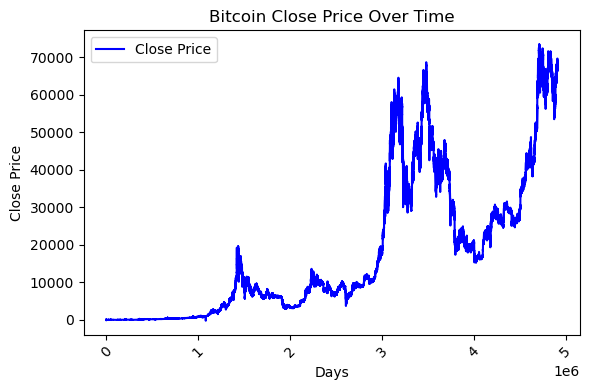

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(btc_prices_csum, label='Close Price', color='blue')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Net

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [10]:
input_window = 7
output_window = 1
batch_size = 128  # batch size

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)    # 0::2 means start from 0 and step 2
        pe[:, 1::2] = torch.cos(position * div_term)    # 1::2 means start from 1 and step 2
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, num_heads=10, hidden_size=128, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        
        # Add input projection layer
        self.input_projection = nn.Linear(feature_size, hidden_size)
        
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        encoder_layers = TransformerEncoderLayer(hidden_size, num_heads, hidden_size*4, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)
        self.input_projection.bias.data.zero_()
        self.input_projection.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        # Project input to higher dimension
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output
    
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.tril(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [50]:
def create_sequences(data, input_window, output_window):
    """Create sequences for time series prediction"""
    sequences = []
    targets = []
    
    for i in range(len(data) - input_window - output_window + 1):
        seq = data[i:i+input_window]
        target = data[i+input_window:i+input_window+output_window]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
btc_prices_scaled = scaler.fit_transform(bitcoin['close_price'].values.reshape(-1, 1))

# Create sequences
X, y = create_sequences(btc_prices_scaled, input_window, output_window)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [53]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
def train_model(model, train_loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.transpose(0, 1)  # Shape: [seq_len, batch_size, features]
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[-output_window:], target.transpose(0, 1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        total_loss += loss.item()
        
    if scheduler:
        scheduler.step()
        
    return total_loss / len(train_loader)

In [55]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.transpose(0, 1)
            
            output = model(data)
            loss = criterion(output[-output_window:], target.transpose(0, 1))
            total_loss += loss.item()
            
    return total_loss / len(test_loader)

In [56]:
model = TransformerModel(
    feature_size=1,
    num_layers=3,  # Increased from 2
    num_heads=8,   # Adjusted from 10
    hidden_size=256,  # Increased from 128
    dropout=0.1    # Reduced from 0.2
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
early_stopping_patience = 20
no_improvement_count = 0

train_losses = []
val_losses = []

c:\Users\Doosheck\miniconda3\envs\comp\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [57]:
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion)
    val_loss = evaluate_model(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
        # Save best model
        torch.save(model.state_dict(), f'best_model_layers_{model.transformer_encoder.layers.__len__()}_heads_{model.transformer_encoder.layers[0].self_attn.num_heads}_hidden_{model.transformer_encoder.layers[0].linear1.in_features}_inputwindow_{input_window}.pth')
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch}')
        break
    
    if epoch % 2 == 0:
        print(f'Epoch {epoch}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

Epoch 0: Train Loss: 0.002618, Val Loss: 0.000505
Epoch 10: Train Loss: 0.000023, Val Loss: 0.000444
Epoch 20: Train Loss: 0.000013, Val Loss: 0.000854
Early stopping at epoch 24


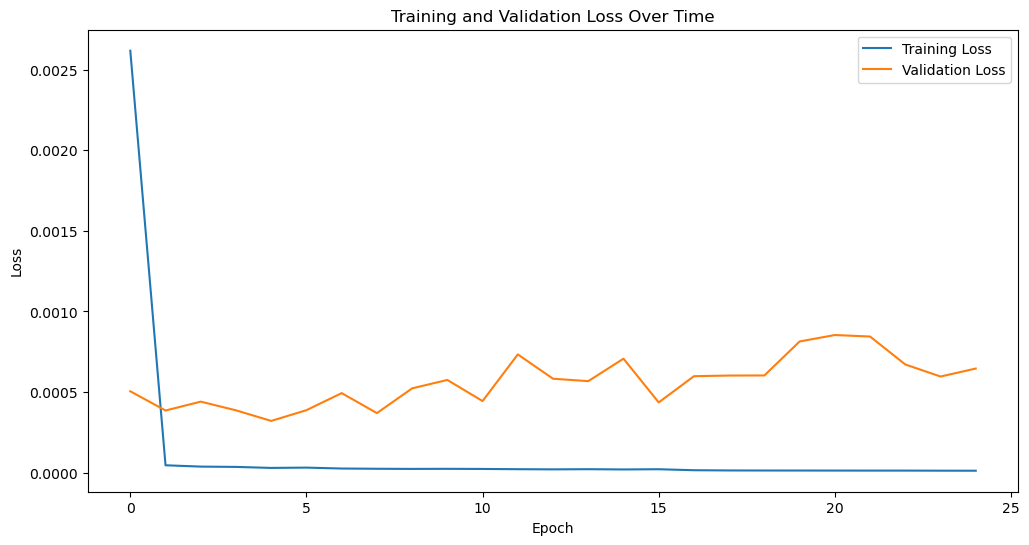

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [59]:
def make_prediction(model, data, scaler):
    model.eval()
    with torch.no_grad():
        data = torch.FloatTensor(data).to(device)
        data = data.unsqueeze(0).transpose(0, 1)  # Add batch dimension and transpose
        prediction = model(data)
        prediction = prediction[-1].cpu().numpy()  # Take last prediction
        # Inverse transform the prediction
        prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
    return prediction

In [60]:
test_predictions = []
actual_values = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        data = data.transpose(0, 1)
        output = model(data)
        predictions = output[-1].cpu().numpy()
        test_predictions.extend(predictions)
        actual_values.extend(target.numpy()[:, -1])

# Convert predictions back to original scale
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actual_values = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1))

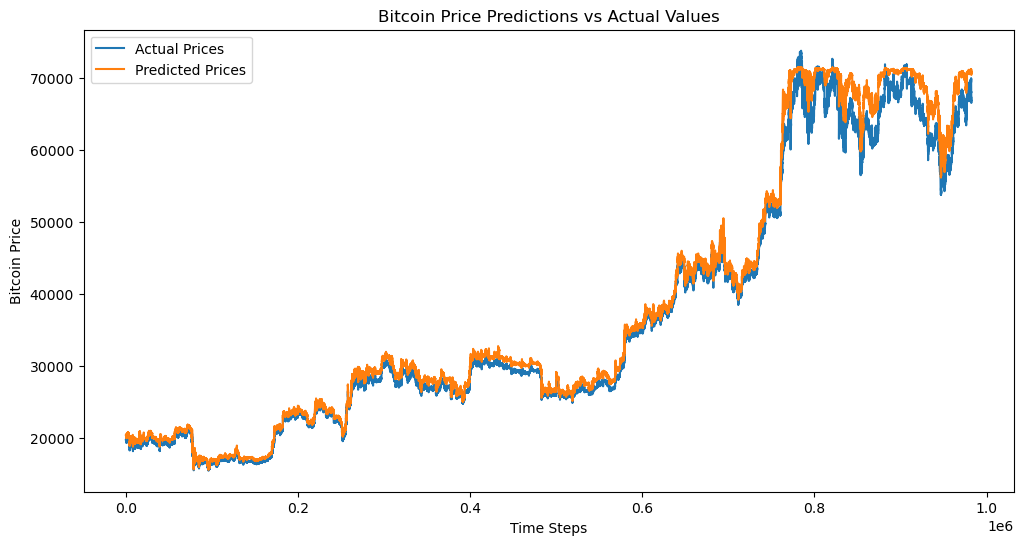

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Predictions vs Actual Values')
plt.legend()
plt.show()